In [236]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
from scipy.sparse import bsr_matrix, csc_matrix, diags, eye

# Eigenvalue Benchmark Problem

In [91]:
W, V = np.linalg.eigh(A)

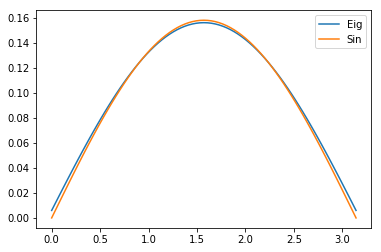

In [92]:
plt.plot(np.linspace(0, np.pi, n), V[:, 0], label='Eig')
l = np.sin(np.linspace(0, np.pi, n))
plt.plot(np.linspace(0, np.pi, n),  l / np.sqrt(np.sum(l**2)), label='Sin')
plt.legend()

# CVXPY

In [96]:
t = cvx.Variable()

In [99]:
objective = cvx.Minimize(-t)
constraints = [A - t * np.eye(n) >> 0]
problem = cvx.Problem(objective, constraints)
optimal_value = problem.solve()

In [100]:
optimal_value

-0.0010011194220271543

In [101]:
W[0]

0.0014676378983795586

# Vectorized Implementation

In [227]:
num_blocks = 2
b = 2
n = b + (num_blocks - 1) * (b - 1)

In [228]:
V = np.zeros(shape=((n ** 2), b ** 2 * num_blocks))

In [229]:
V.shape

(9, 8)

In [230]:
for i in range(num_blocks):
    for l in range(b ** 2):
        j = l // b
        k = l % b
        row_index = (i * (b - 1) + j) * n + (i) * (b - 1) + k
        column_index = l + i  * b ** 2
        print('Inserting 1 at ({0}, {1})'.format(row_index, column_index))
        V[row_index, column_index] = 1

Inserting 1 at (0, 0)
Inserting 1 at (1, 1)
Inserting 1 at (3, 2)
Inserting 1 at (4, 3)
Inserting 1 at (4, 4)
Inserting 1 at (5, 5)
Inserting 1 at (7, 6)
Inserting 1 at (8, 7)


In [ ]:
def form_vectorized_matrix(A_matrices):
    V_Z = form_vectorized_Z()
    V_A = form_vectorized_A(A_matrices)
    # Concat V_A to V_Z

In [174]:
def form_vectorized_Z():
    for i in range(num_blocks):
        for l in range(b ** 2):
            j = l // b
            k = l % b
            row_index = (i * (b - 1) + j) * n + (i) * (b - 1) + k
            column_index = l + i  * b ** 2
            print('Inserting 1 at ({0}, {1})'.format(row_index, column_index))
            V[row_index, column_index] = 1
    return V

In [171]:
def form_vectorized_A(A_matrices):
    # Parameter: A_matrices is a list of A_1, A_2, ..., A_k.
    #   A_matrices does NOT include A_0
    V = np.zeros(shape=(n ** 2, len(A_matrices)))
    for index in range(len(A_matrices)):
        V[:, index] = A_matrices[index].flatten()
    return V

In [191]:
def form_laplacian():
    A_0_sparse = diags(diagonals=[-1.0, 2.0, -1.0], offsets = [-1, 0, 1], shape=(n, n))
    return A_0_sparse.tocsc()

In [202]:
def form_vectorized_laplacian():
    A_0_sparse = form_laplacian()
    nz = A_0_sparse.nonzero()
    return A_0_sparse[nz].flatten(), nz

In [203]:
def generate_sparse_lambda(A_0):
    # Parameter: A_0 is a sparse matrix
    nz_rows, nz_cols = A_0.nonzero()
    A_0[A_0]
    Lambda = np.zeros(len(nz_rows))

In [231]:
A_0, nz = form_vectorized_laplacian()

In [235]:
form_laplacian().todense()

matrix([[ 2., -1.,  0.],
        [-1.,  2., -1.],
        [ 0., -1.,  2.]])

In [172]:
A_matrices = [np.eye(n)]

In [173]:
form_vectorized_A(A_matrices)

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.]])

# Test Implementation

In [177]:
num_A = 1
num_blocks = 40
b = 3
n = 3 + (num_blocks - 1) * 2

In [214]:
# Constants for eigenvalue problem
c = np.array([-1.0])
# Primal Variables
x = np.zeros(num_A)
lambda_dual_var = csc_matrix((n, n))

In [216]:
def run_alternating_projections():
    pass

In [246]:
def projection_strong_duality(A_0_sparse, A_0_nz, 
                              A_sparse_list, A_nz_list, 
                              c, 
                              x_primal_var, z_primal_var_list, 
                              lambda_dual_var,
                              sigma_dual_var_list):
    # Precompute
    A_0_sparse_vectorized = A_0_sparse[A_0_nz]
    A_i_sparse_vectorized_list = [A_sparse_list[i][A_nz_list[i]] for i in range(len(A_sparse_list))]
    
    # Project y = (x, lambda) onto c'x + d'eta - tr(Lambda * A_0) = 0
    # Equivalently, projecting y onto Cy = d, where C = [c', -vec(A_0.nz)], d = 0
    C = np.hstack(c, A_0_sparse_vectorized)
    d = np.zeros(C.shape[0])
    y = np.vstack(x_primal_var, lambda_dual_var[A_0_nz])
    pinv_C = np.pinv(C)
    y_prime = pinv_C.dot(d) + (scipy.sparse.eye(pinv_C.shape[0]) - pinv_C.dot(C)).dot(y)
    x_primal_var = y_prime[0:len(x_primal_var)]
    lambda_dual_var[A_0_nz] = y_prime[len(x_primal_var):]

In [247]:
def projection_dual_feasibility_equality_1(A_0_sparse, A_0_nz, 
                                          A_sparse_list, A_nz_list, 
                                          c, 
                                          x_primal_var, z_primal_var_list, 
                                          lambda_dual_var,
                                          sigma_dual_var_list):
    # For each i, project c, lambda such that c[i] + tr(Lambda * A_i) = 0
    # Equivalently, project onto Cy = d, where C = [vec(A_i.nz)'] and y = Lambda[A_i.nz], d = -c[i]
    for i in range(len(A_i_sparse_list)):
        C = A_i_sparse_vectorized_list[i]
        d = np.array([-c[i]])
        y = lambda_dual_var[A_nz_list[i]]
        pinv_C = np.pinv(C)
        y_prime = pinv_C.dot(d) + (scipy.sparse.eye(pinv_C.shape[0]) - pinv_C.dot(C)).dot(y)
        lambda_dual_var[A_nz_list[i]] = y_prime

In [248]:
def projection_dual_feasibility_equality_2(A_0_sparse, A_0_nz, 
                                          A_sparse_list, A_nz_list, 
                                          c, 
                                          x_primal_var, z_primal_var_list, 
                                          lambda_dual_var,
                                          sigma_dual_var_list):
    # Project onto Sigma_i = -E_i' Lambda E_i
    # generate indices of the nonzero entires for block sparsity pattern
    for i in range(num_blocks):
        C = np.hstack(np.eye(b**2), -np.eye(b**2))
        d = np.zeros(b**2)
        diag_idx = (b-1)*i
        y = np.hstack(sigma_dual_var_list[i].flatten(),
                      lambda_dual_var[diag_idx:diag_idx+b, diag_idx:diag_idx+b].flatten())
        pinv_C = np.pinv(C)
        y_prime = pinv_C.dot(d) + (scipy.sparse.eye(pinv_C.shape[0]) - pinv_C.dot(C)).dot(y)
        sigma_dual_var_list[i] = y_prime[:b**2]
        lambda_dual_var[diag_idx:diag_idx+b, diag_idx:diag_idx+b] = y_prime[b**2:].reshape(b,b)

In [249]:
def projection_primal_feasibility_equality(A_0_sparse, A_0_nz, 
                                          A_sparse_list, A_nz_list, 
                                          c, 
                                          x_primal_var, z_primal_var_list, 
                                          lambda_dual_var,
                                          sigma_dual_var_list):
    # Project onto L(x) = \sum E_i Z_i E_i'
    # generate indices of the nonzero entires for block sparsity pattern
    matrix_to_vector= {} # Map (i, j) to k
    vector_to_matrix_set = set() 
    for block_index in range(num_blocks):
        top_left = ((b - 1) * block_index, (b - 1) * block_index)
        for (di, dj) in itertools.product(range(b), range(b)):
            vector_to_matrix.add((top_left[0] + di, top_left[1] + dj))
    vector_to_matrix = list(vector_to_matrix_set)
    sparsity_pattern_rows = np.array([op[0] for op in vector_to_matrix])
    sparsity_pattern_cols = np.array([op[1] for op in vector_to_matrix])
    matrix_to_vector = {p:i for i, p in enumerate(vector_to_matrix)}
    
    cols_z = scipy.sparse.csr_matrix((len(vector_to_matrix), b**2 * num_blocks))
    rows_to_Z_idx = []
    # First map the Z_i matrices
    for curr_block_idx in range(num_blocks):
        for i, j in itertools.product(range(b), range(b)):
            ni, nj = curr_block_idx*(b-1) + i, curr_block_idx*(b-1) + j
            # Generate the basis vectors
            cols_z[matrix_to_vector[(ni, nj)], curr_block_idx*(b**2) + i*b + j] = 1
            
    cols_A = scipy.sparse.csr_matrix((len(vector_to_matrix), len(A_sparse_list)))
    for i in range(len(A_sparse_list)):
        cols_A[:, i] = A_sparse_list[i][sparsity_pattern_rows, sparsity_pattern_cols]
        
    z_vector = np.array(b**2 * num_blocks)
    for block_idx in range(num_blocks):
        for i, j in itertools.product(range(b), range(b)):
            z_vector[block_idx * (b ** 2) + (i * b) + j ] = z_primal_var_list[block_idx][i, j]
    y = np.vstack(z_vector, x_primal_var)
    d = A_0_sparse[sparsity_pattern_rows, sparsity_pattern_cols].todense()
    C = scipy.sparse.hstack(-cols_z, cols_A).todense()
    pinv_C = np.pinv(C)
    y_prime = pinv_C.dot(d) + (scipy.sparse.eye(pinv_C.shape[0]) - pinv_C.dot(C)).dot(y)
    
    for block_idx in range(num_blocks):
        for i, j in itertools.product(range(b), range(b)):
            z_primal_var_list[block_idx][i, j] = y_prime[block_idx * (b ** 2) + (i * b) + j ]
            
    x_primal_var = y_prime[-len(x_primal_var):]

In [245]:
def alternating_projections_iteration(A_0_sparse, A_0_nz, 
                                      A_sparse_list, A_nz_list, 
                                      c, 
                                      x_primal_var, z_primal_var_list, 
                                      lambda_dual_var,
                                      sigma_dual_var_list):
    
    projection_strong_duality(A_0_sparse, A_0_nz, 
                              A_sparse_list, A_nz_list, 
                              c, 
                              x_primal_var, z_primal_var_list, 
                              lambda_dual_var,
                              sigma_dual_var_list)

    projection_dual_feasibility_equality_1(A_0_sparse, A_0_nz, 
                                              A_sparse_list, A_nz_list, 
                                              c, 
                                              x_primal_var, z_primal_var_list, 
                                              lambda_dual_var,
                                              sigma_dual_var_list):
        
    projection_dual_feasibility_equality_2(A_0_sparse, A_0_nz, 
                                          A_sparse_list, A_nz_list, 
                                          c, 
                                          x_primal_var, z_primal_var_list, 
                                          lambda_dual_var,
                                          sigma_dual_var_list):
    
    
    projection_primal_feasibility_equality(A_0_sparse, A_0_nz, 
                                          A_sparse_list, A_nz_list, 
                                          c, 
                                          x_primal_var, z_primal_var_list, 
                                          lambda_dual_var,
                                          sigma_dual_var_list):
            
            
            
    

In [237]:
l = [1, 2, 3, 4, 5]

In [238]:
l[-2:]

[4, 5]